In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
epochs = 10
log_interval = 100
learning_rate = 1e-3
latent_dim = 20 # 값이 크면 모델이 더 많은 정보를 잠재 공간에 인코딩할 수 있지만, 너무 큰 값은 과적합 초래.

In [3]:
seed = 975
torch.manual_seed(seed)

In [4]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available() and not use_cuda

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [5]:
device

device(type='cuda')

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
                          batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
                         batch_size=batch_size, shuffle=False, **kwargs)


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Latent space
        self.fc_mu = nn.Linear(latent_dim, latent_dim)  # mu
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)  # logvar

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:  # 첫 번째 배치에 대해서만 이미지 시각화
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
                comparison = comparison.cpu().numpy()
                fig, axes = plt.subplots(2, n, figsize=(10, 2))
                for idx in range(n):
                    axes[0, idx].imshow(comparison[idx].reshape(28, 28), cmap='gray')
                    axes[0, idx].axis('off')
                    axes[1, idx].imshow(comparison[idx + n].reshape(28, 28), cmap='gray')
                    axes[1, idx].axis('off')
                plt.show()


    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/60000 (0%)]	Loss: 603.284485
Train Epoch: 1 [6400/60000 (11%)]	Loss: 188.052979
Train Epoch: 1 [12800/60000 (21%)]	Loss: 158.192123
Train Epoch: 1 [19200/60000 (32%)]	Loss: 140.462448
Train Epoch: 1 [25600/60000 (43%)]	Loss: 141.710541
Train Epoch: 1 [32000/60000 (53%)]	Loss: 134.347565
Train Epoch: 1 [38400/60000 (64%)]	Loss: 134.426270
Train Epoch: 1 [44800/60000 (75%)]	Loss: 127.871765
Train Epoch: 1 [51200/60000 (85%)]	Loss: 125.487396
Train Epoch: 1 [57600/60000 (96%)]	Loss: 121.247414
====> Epoch: 1 Average loss: 151.5326


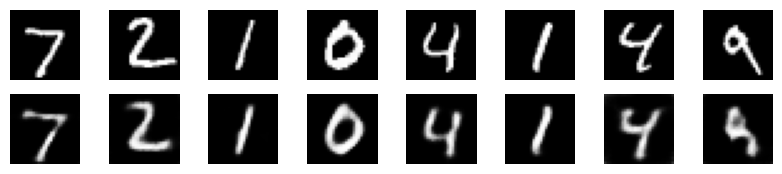

====> Test set loss: 119.7682


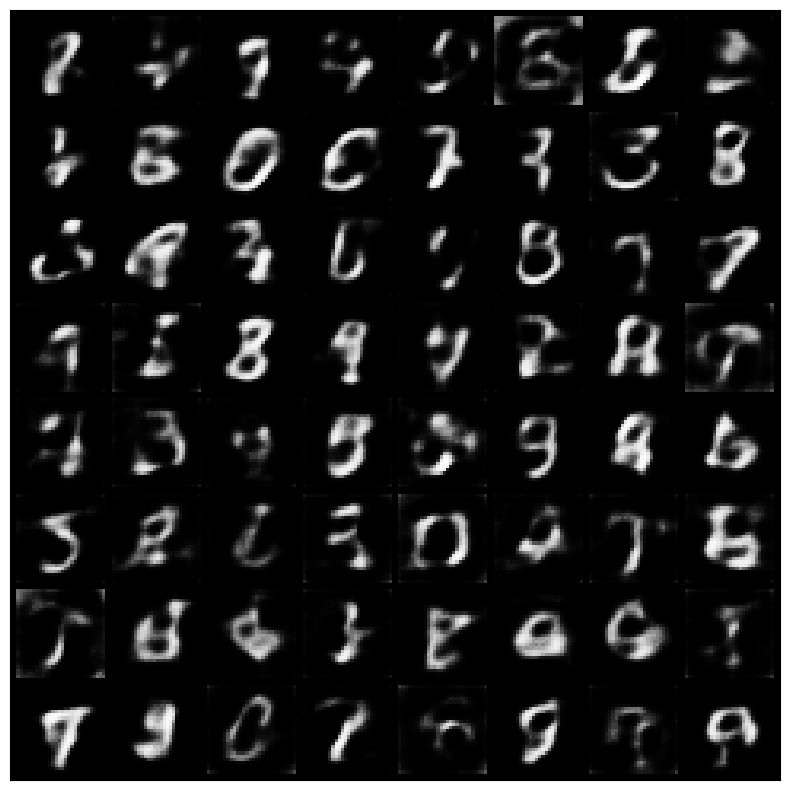

Train Epoch: 2 [0/60000 (0%)]	Loss: 123.753922
Train Epoch: 2 [6400/60000 (11%)]	Loss: 111.776894
Train Epoch: 2 [12800/60000 (21%)]	Loss: 117.523758
Train Epoch: 2 [19200/60000 (32%)]	Loss: 117.124184
Train Epoch: 2 [25600/60000 (43%)]	Loss: 110.477203
Train Epoch: 2 [32000/60000 (53%)]	Loss: 117.971428
Train Epoch: 2 [38400/60000 (64%)]	Loss: 120.784332
Train Epoch: 2 [44800/60000 (75%)]	Loss: 118.630272
Train Epoch: 2 [51200/60000 (85%)]	Loss: 115.246368
Train Epoch: 2 [57600/60000 (96%)]	Loss: 107.516800
====> Epoch: 2 Average loss: 114.0544


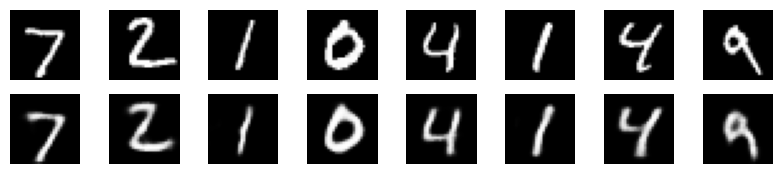

====> Test set loss: 109.0217


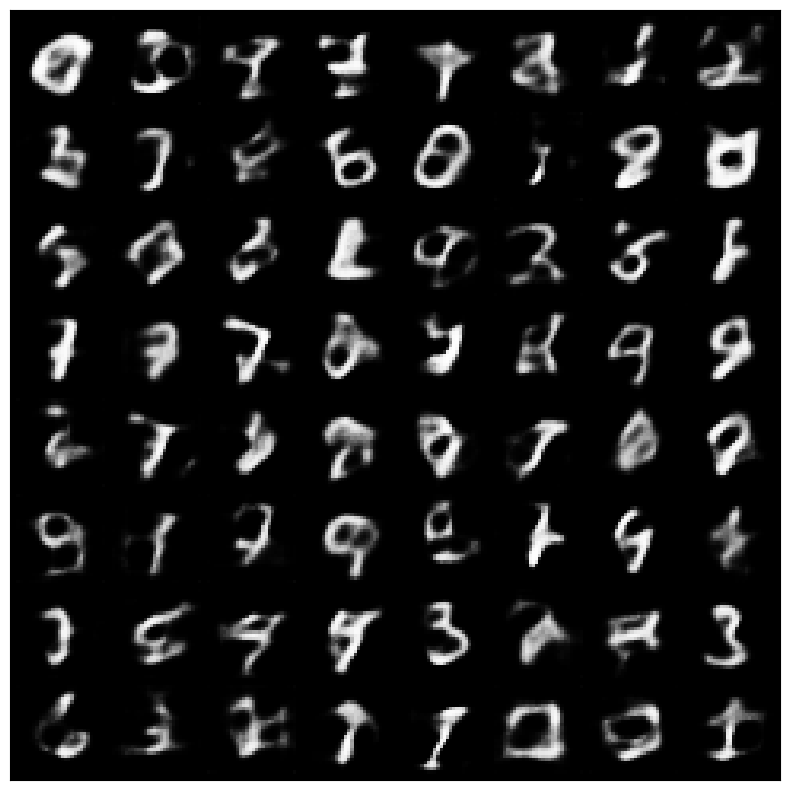

Train Epoch: 3 [0/60000 (0%)]	Loss: 107.244156
Train Epoch: 3 [6400/60000 (11%)]	Loss: 111.151794
Train Epoch: 3 [12800/60000 (21%)]	Loss: 107.545837
Train Epoch: 3 [19200/60000 (32%)]	Loss: 103.625839
Train Epoch: 3 [25600/60000 (43%)]	Loss: 110.049576
Train Epoch: 3 [32000/60000 (53%)]	Loss: 102.043304
Train Epoch: 3 [38400/60000 (64%)]	Loss: 109.731949
Train Epoch: 3 [44800/60000 (75%)]	Loss: 111.193054
Train Epoch: 3 [51200/60000 (85%)]	Loss: 109.275803
Train Epoch: 3 [57600/60000 (96%)]	Loss: 108.064041
====> Epoch: 3 Average loss: 108.1917


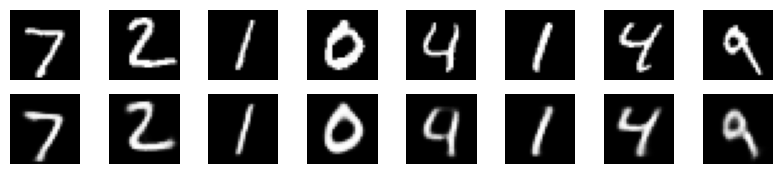

====> Test set loss: 106.1821


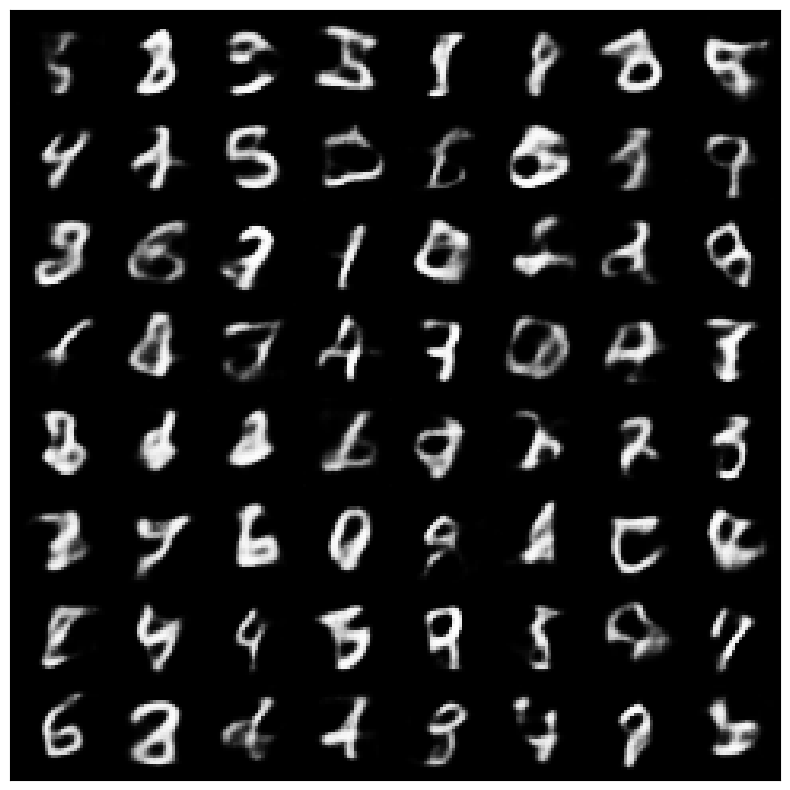

Train Epoch: 4 [0/60000 (0%)]	Loss: 109.160927
Train Epoch: 4 [6400/60000 (11%)]	Loss: 107.704498
Train Epoch: 4 [12800/60000 (21%)]	Loss: 105.398109
Train Epoch: 4 [19200/60000 (32%)]	Loss: 108.660980
Train Epoch: 4 [25600/60000 (43%)]	Loss: 112.646896
Train Epoch: 4 [32000/60000 (53%)]	Loss: 105.630592
Train Epoch: 4 [38400/60000 (64%)]	Loss: 107.086830
Train Epoch: 4 [44800/60000 (75%)]	Loss: 105.338760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 106.694611
Train Epoch: 4 [57600/60000 (96%)]	Loss: 105.314323
====> Epoch: 4 Average loss: 105.9975


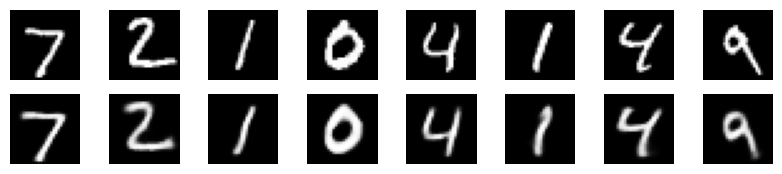

====> Test set loss: 104.6646


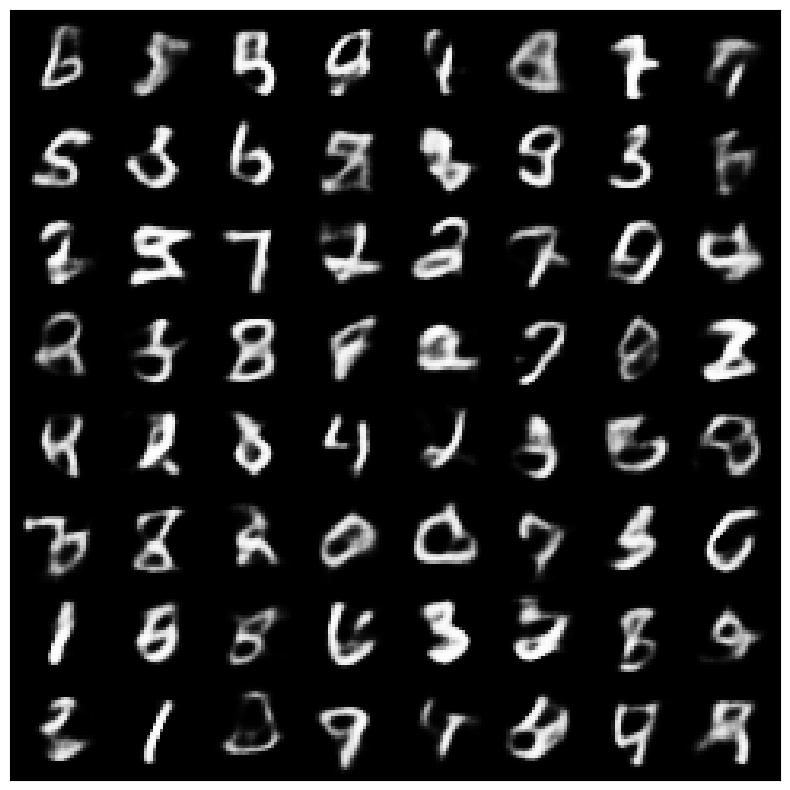

Train Epoch: 5 [0/60000 (0%)]	Loss: 106.150970
Train Epoch: 5 [6400/60000 (11%)]	Loss: 105.105652
Train Epoch: 5 [12800/60000 (21%)]	Loss: 106.069962
Train Epoch: 5 [19200/60000 (32%)]	Loss: 109.734695
Train Epoch: 5 [25600/60000 (43%)]	Loss: 97.590569
Train Epoch: 5 [32000/60000 (53%)]	Loss: 103.494919
Train Epoch: 5 [38400/60000 (64%)]	Loss: 106.148659
Train Epoch: 5 [44800/60000 (75%)]	Loss: 110.953186
Train Epoch: 5 [51200/60000 (85%)]	Loss: 102.181374
Train Epoch: 5 [57600/60000 (96%)]	Loss: 108.218811
====> Epoch: 5 Average loss: 104.7677


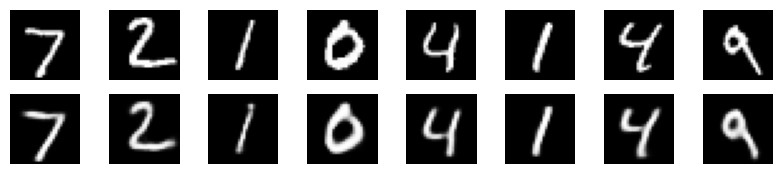

====> Test set loss: 103.8261


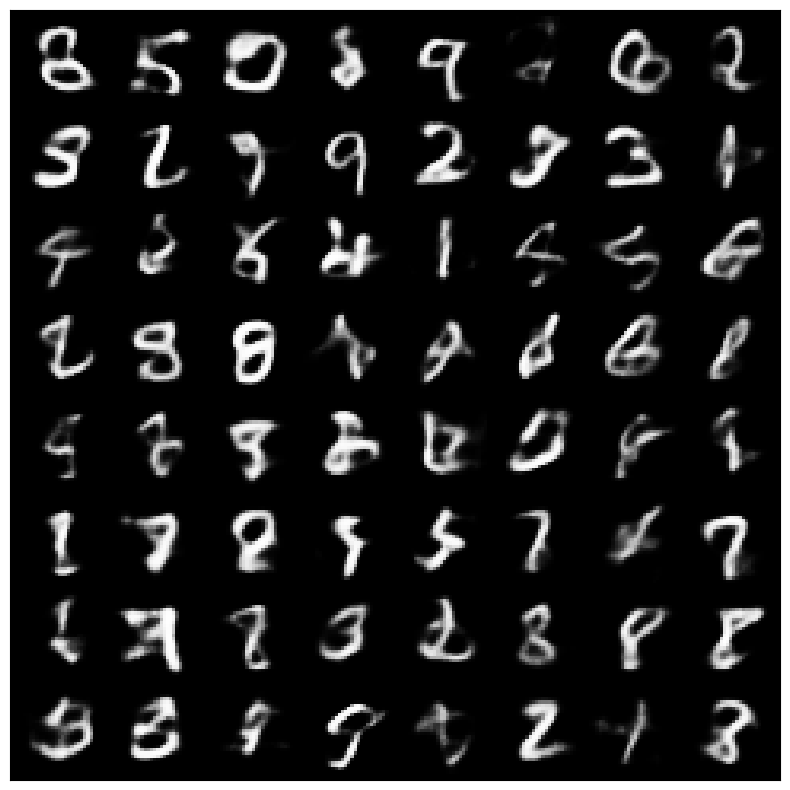

Train Epoch: 6 [0/60000 (0%)]	Loss: 104.180504
Train Epoch: 6 [6400/60000 (11%)]	Loss: 108.533020
Train Epoch: 6 [12800/60000 (21%)]	Loss: 101.601906
Train Epoch: 6 [19200/60000 (32%)]	Loss: 105.211151
Train Epoch: 6 [25600/60000 (43%)]	Loss: 104.274460
Train Epoch: 6 [32000/60000 (53%)]	Loss: 106.420143
Train Epoch: 6 [38400/60000 (64%)]	Loss: 104.149422
Train Epoch: 6 [44800/60000 (75%)]	Loss: 99.427948
Train Epoch: 6 [51200/60000 (85%)]	Loss: 110.987221
Train Epoch: 6 [57600/60000 (96%)]	Loss: 108.001221
====> Epoch: 6 Average loss: 103.8793


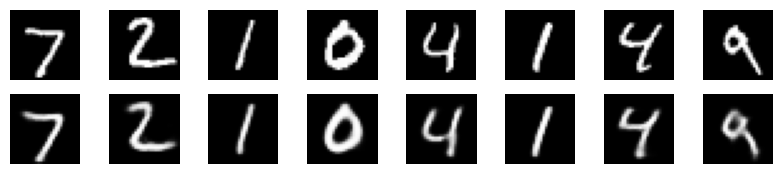

====> Test set loss: 103.0798


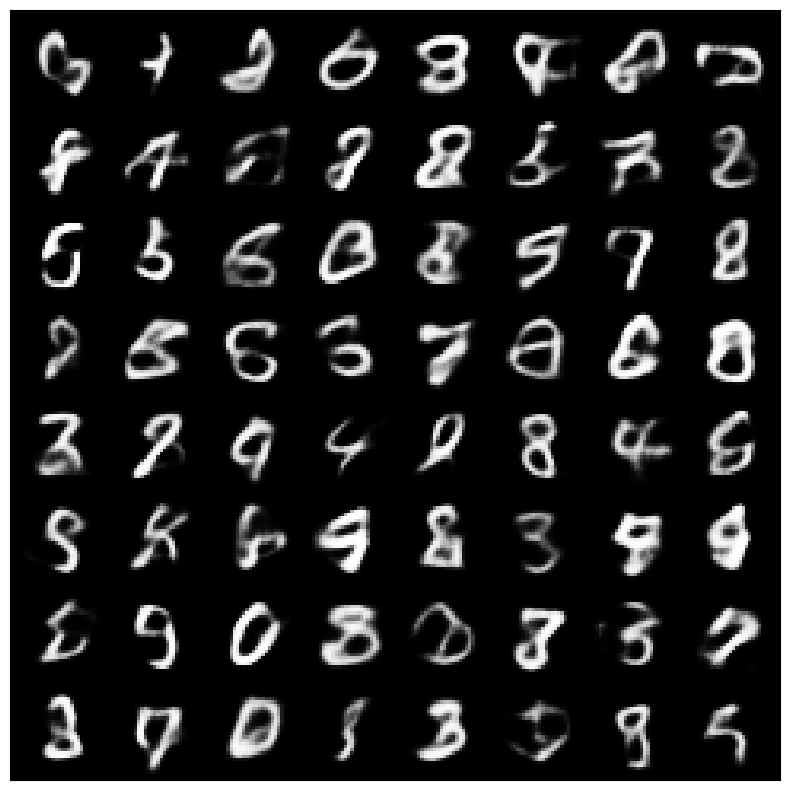

Train Epoch: 7 [0/60000 (0%)]	Loss: 104.580399
Train Epoch: 7 [6400/60000 (11%)]	Loss: 108.446129
Train Epoch: 7 [12800/60000 (21%)]	Loss: 107.786705
Train Epoch: 7 [19200/60000 (32%)]	Loss: 104.757126
Train Epoch: 7 [25600/60000 (43%)]	Loss: 103.684303
Train Epoch: 7 [32000/60000 (53%)]	Loss: 102.493744
Train Epoch: 7 [38400/60000 (64%)]	Loss: 105.663078
Train Epoch: 7 [44800/60000 (75%)]	Loss: 104.335754
Train Epoch: 7 [51200/60000 (85%)]	Loss: 97.696213
Train Epoch: 7 [57600/60000 (96%)]	Loss: 106.022530
====> Epoch: 7 Average loss: 103.3032


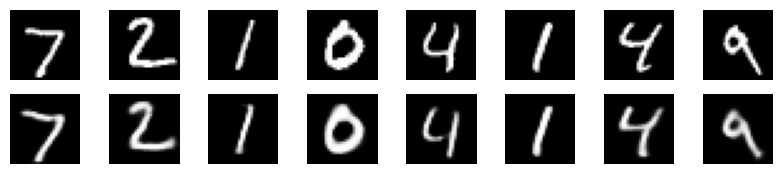

====> Test set loss: 102.7651


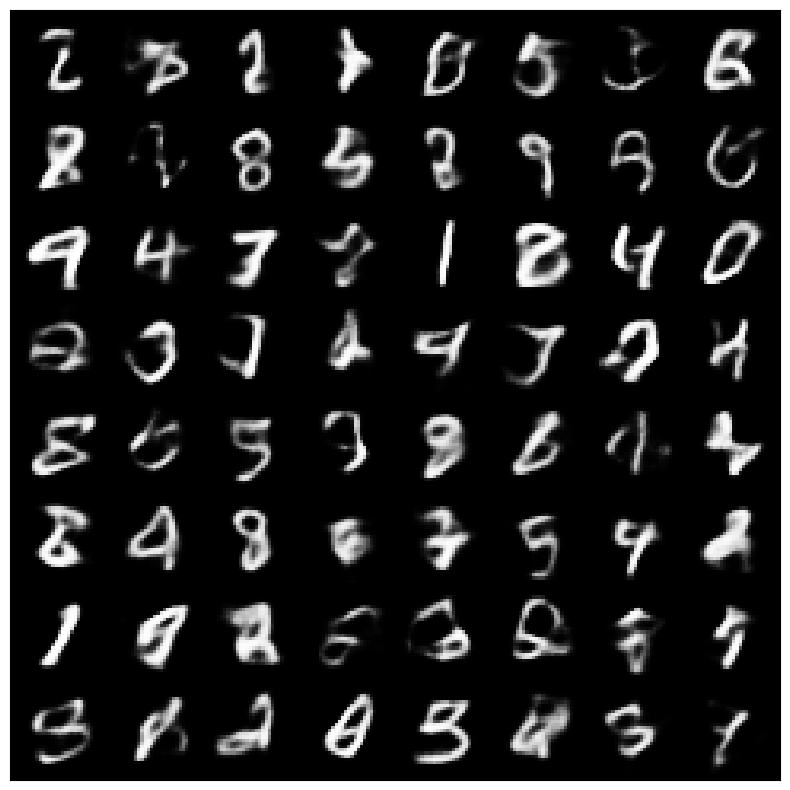

Train Epoch: 8 [0/60000 (0%)]	Loss: 100.737526
Train Epoch: 8 [6400/60000 (11%)]	Loss: 105.320389
Train Epoch: 8 [12800/60000 (21%)]	Loss: 99.533737
Train Epoch: 8 [19200/60000 (32%)]	Loss: 102.733269
Train Epoch: 8 [25600/60000 (43%)]	Loss: 101.268150
Train Epoch: 8 [32000/60000 (53%)]	Loss: 98.513359
Train Epoch: 8 [38400/60000 (64%)]	Loss: 105.142319
Train Epoch: 8 [44800/60000 (75%)]	Loss: 102.491600
Train Epoch: 8 [51200/60000 (85%)]	Loss: 104.678436
Train Epoch: 8 [57600/60000 (96%)]	Loss: 106.827927
====> Epoch: 8 Average loss: 102.7372


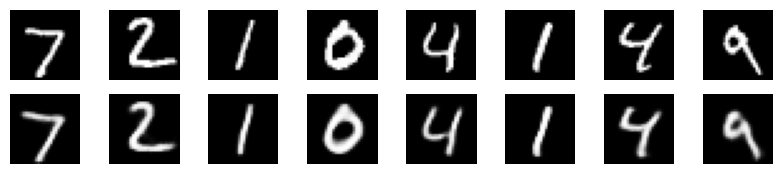

====> Test set loss: 102.3949


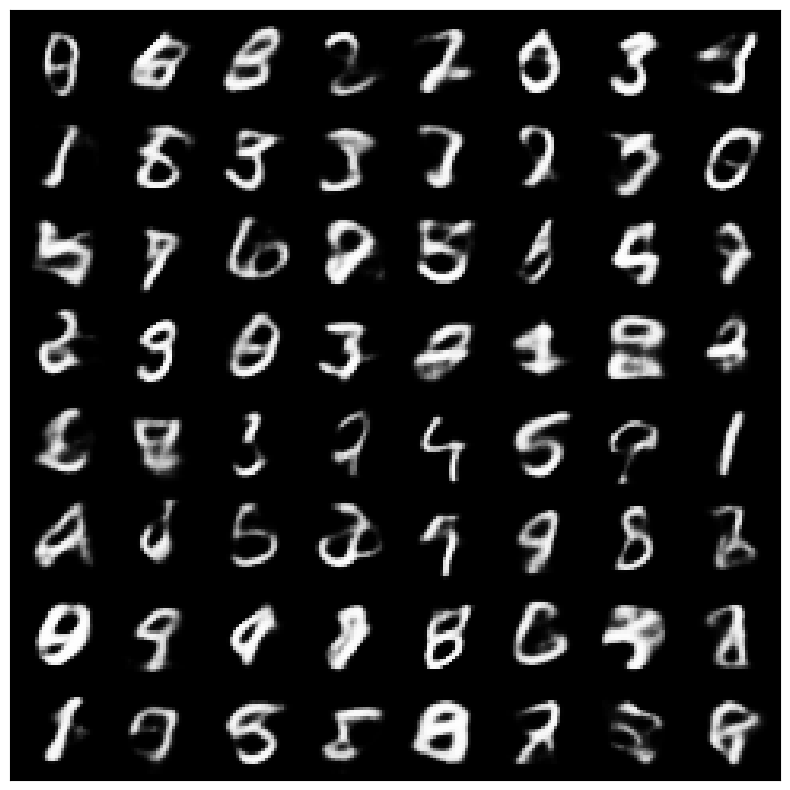

Train Epoch: 9 [0/60000 (0%)]	Loss: 99.834030
Train Epoch: 9 [6400/60000 (11%)]	Loss: 102.999825
Train Epoch: 9 [12800/60000 (21%)]	Loss: 99.261505
Train Epoch: 9 [19200/60000 (32%)]	Loss: 97.846283
Train Epoch: 9 [25600/60000 (43%)]	Loss: 103.843872
Train Epoch: 9 [32000/60000 (53%)]	Loss: 104.550171
Train Epoch: 9 [38400/60000 (64%)]	Loss: 105.673470
Train Epoch: 9 [44800/60000 (75%)]	Loss: 104.163010
Train Epoch: 9 [51200/60000 (85%)]	Loss: 102.205215
Train Epoch: 9 [57600/60000 (96%)]	Loss: 103.446495
====> Epoch: 9 Average loss: 102.3745


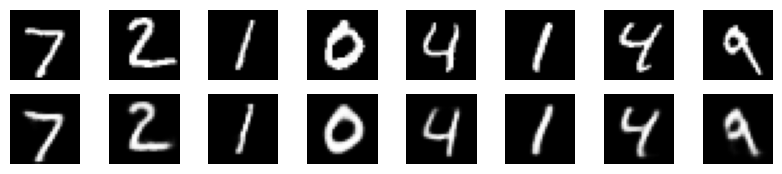

====> Test set loss: 101.7628


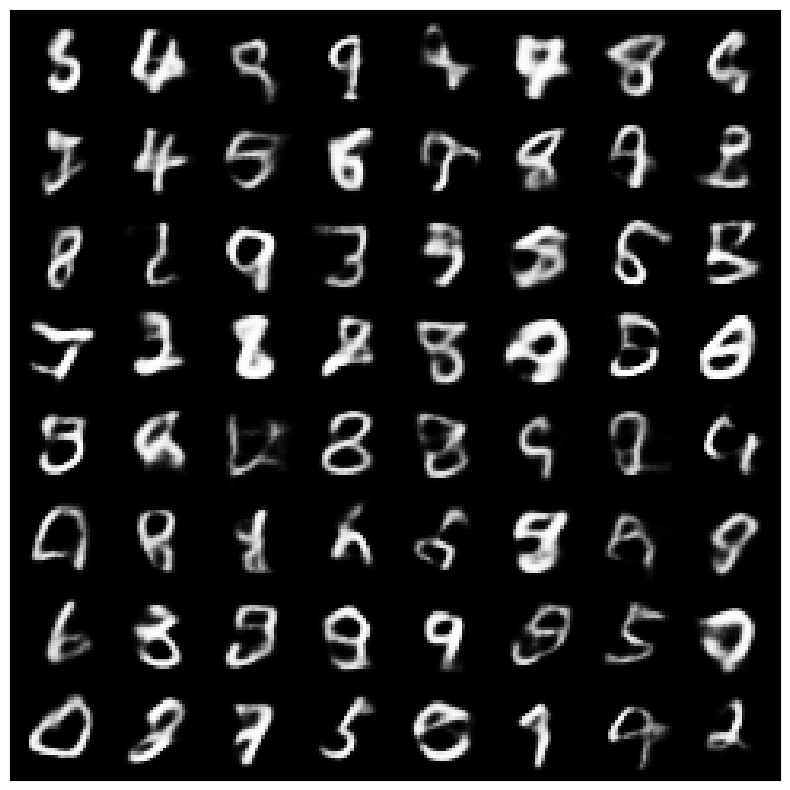

Train Epoch: 10 [0/60000 (0%)]	Loss: 102.132149
Train Epoch: 10 [6400/60000 (11%)]	Loss: 100.656326
Train Epoch: 10 [12800/60000 (21%)]	Loss: 101.298393
Train Epoch: 10 [19200/60000 (32%)]	Loss: 102.286957
Train Epoch: 10 [25600/60000 (43%)]	Loss: 97.873093
Train Epoch: 10 [32000/60000 (53%)]	Loss: 98.719742
Train Epoch: 10 [38400/60000 (64%)]	Loss: 100.994316
Train Epoch: 10 [44800/60000 (75%)]	Loss: 107.408493
Train Epoch: 10 [51200/60000 (85%)]	Loss: 99.109573
Train Epoch: 10 [57600/60000 (96%)]	Loss: 104.478714
====> Epoch: 10 Average loss: 101.9590


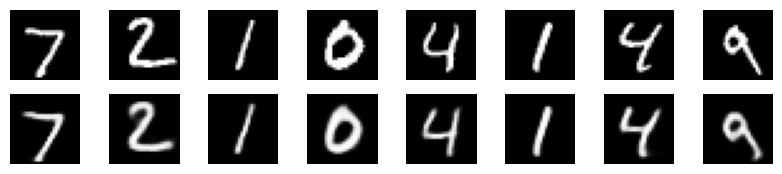

====> Test set loss: 101.8286


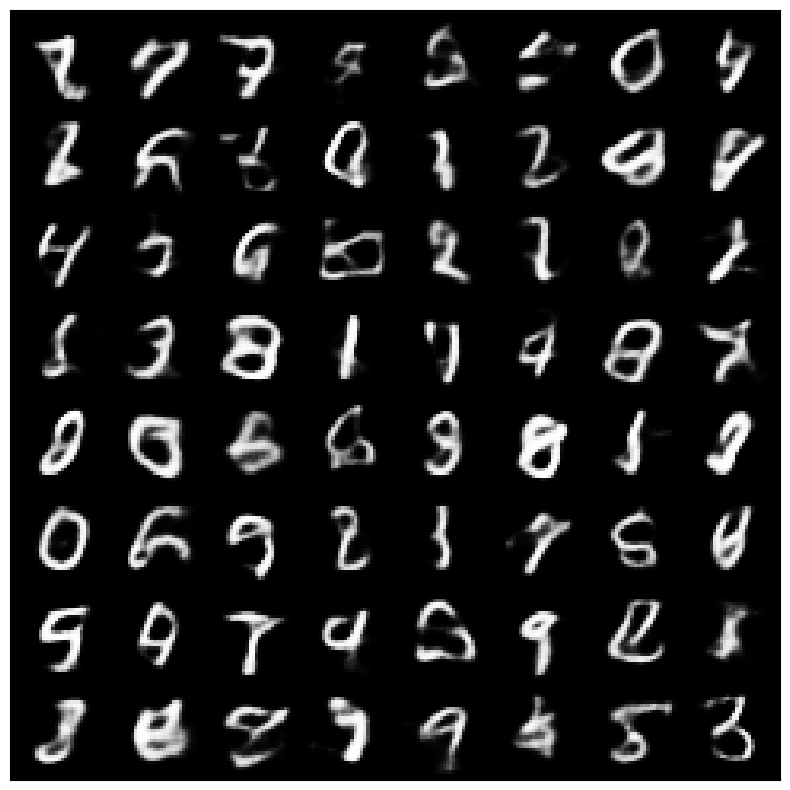

In [ ]:
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, latent_dim).to(device) # 64 -> 샘플로 생성할 이미지 갯수
            sample = model.decode(sample).cpu()
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(make_grid(sample.view(64, 1, 28, 28)).permute(1, 2, 0))
            plt.show()

In [ ]:
def visualize_class_samples(class_idx, num_samples=10):
    model.eval()
    with torch.no_grad():
        mu, logvar = get_class_latent_distribution(train_loader, class_idx)
        samples = model.reparameterize(mu, logvar)
        recon_images = model.decode(samples).cpu()

        # recon_images의 차원이 [num_samples, 1, 28, 28]라고 가정하면, 이를 2D 이미지 형태로 변환
        recon_images = recon_images.view(num_samples, 28, 28)

        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
        for i, ax in enumerate(axes):
            ax.imshow(recon_images[i], cmap='gray')
            ax.axis('off')
        plt.show()



def get_class_latent_distribution(loader, class_idx):
    mu_total, logvar_total = [], []
    for data, target in loader:
        data = data[target == class_idx].to(device)
        if data.size(0) > 0:
            mu, logvar = model.encode(data)
            mu_total.append(mu)
            logvar_total.append(logvar)
    mu_total = torch.cat(mu_total).mean(0)
    logvar_total = torch.cat(logvar_total).mean(0)
    return mu_total, logvar_total

# 예를 들어, 클래스 0의 이미지 생성 및 시각화
visualize_class_samples(0)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)